In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
from PIL import Image

import tensorflow as tf
#tf.enable_eager_execution()
#import tensorflow.contrib.eager as tfe
import sys
import os
from sklearn.utils import shuffle
from random import sample
# from cache import cache
# import pydot
# import graphviz
# from sklearn.model_selection import train_test_split
import time
import pickle
from tqdm import tqdm
# import copy
# import re
# import random
import requests
from urllib.request import urlopen

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape, \
BatchNormalization, GlobalAveragePooling2D, Conv2D
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input as VGG16_preprocess_input
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.applications.inception_v3 import decode_predictions
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
#from tensorflow.python.keras.utils import plot_model
#from tensorflow.python.keras.utils import to_categorical

In [3]:
tf.__version__

'2.1.0'

In [4]:
tf.keras.__version__

'2.2.4-tf'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3418779096220549548
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 372197011045534863
physical_device_desc: "device: XLA_CPU device"
]


In [6]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [7]:
print(tf.test.is_built_with_cuda())

True


# Load Data for Modeling

In [8]:
# get data from json
with open("data/caltech_images_20190919.json", 'r') as f:
    annotations = json.load(f)

annot_df = pd.DataFrame.from_dict(annotations['annotations'])
image_df = pd.DataFrame.from_dict(annotations['images'])

# get animal name map 
category_id = []
category_name = []

for i in annotations['categories']:
    category_id.append(i['id'])
    category_name.append(i['name'])
    
category_dict = dict(zip(category_id, category_name))
annot_df['category_name'] = annot_df['category_id'].map(category_dict)

# drop duplicate annotations
annot_df.sort_values("image_id", inplace = True) 
annot_df_nodup = annot_df.drop_duplicates(subset ="image_id", keep = 'first')

# merge annotation and image data together
image_df.rename(columns={"id": "image_id"}, inplace=True)
image_df.sort_values("image_id", inplace = True) 
image_df_annot = pd.concat([image_df.set_index('image_id'), annot_df_nodup.set_index('image_id')],\
                           axis=1, join='inner').reset_index()

image_df_annot.head()

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name
0,5858bf1e-23d2-11e8-a6a3-ec086b02610b,1,2014-07-10 14:20:20,6fc5ac4a-5567-11e8-b3db-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf1e-23d2-11e8-a6a3-ec086b02610b.jpg,1,52acca15-7d6d-11e7-884d-7845c41c2c67,30,empty
1,5858bf20-23d2-11e8-a6a3-ec086b02610b,1,2014-05-26 13:44:00,6fbb3c73-5567-11e8-b378-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf20-23d2-11e8-a6a3-ec086b02610b.jpg,1,f77c64a8-7d6e-11e7-884d-7845c41c2c67,30,empty
2,5858bf21-23d2-11e8-a6a3-ec086b02610b,1,2014-09-16 08:16:51,7006f717-5567-11e8-b4c6-dca9047ef277,1494,2048,114,Erin Boydston,test/5858bf21-23d2-11e8-a6a3-ec086b02610b.jpg,1,1aa83e59-7d71-11e7-884d-7845c41c2c67,10,rabbit
3,5858bf22-23d2-11e8-a6a3-ec086b02610b,1,2014-05-27 14:57:44,6fbd60e3-5567-11e8-a122-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf22-23d2-11e8-a6a3-ec086b02610b.jpg,1,45913ae8-7d6d-11e7-884d-7845c41c2c67,30,empty
4,5858bf23-23d2-11e8-a6a3-ec086b02610b,1,2014-06-06 12:31:06,6fbf5a47-5567-11e8-9655-dca9047ef277,1494,2048,96,Erin Boydston,test/5858bf23-23d2-11e8-a6a3-ec086b02610b.jpg,1,5f7e6e7a-7d6e-11e7-884d-7845c41c2c67,30,empty


# Show Image

In [9]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

def show_image(path, category):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    #path = filenames_train[idx]
    #caption = captions_train[idx]

    # Print the captions for this image.
    print("Category: " + category)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()
    
def show_image_by_category(images=1, category = 'any'):
    path = 'data/cct_images/'
    if category == 'any':
        samples = image_df_annot.sample(n=images)
    else:
        samples = image_df_annot[image_df_annot['category_name']==category].sample(n=images)
    for id, sample in samples.iterrows():
        image_id = sample['image_id']
        filename= 'data/cct_images/'+image_id + '.jpg'
        print(sample['category_name'] + " " + image_id)
        img = load_image(filename)
        plt.imshow(img)
        plt.show()    

In [10]:
#show_image_by_category(3, 'deer')

# Define Prediction Class

In [11]:
classes = ['rodent','squirrel','rabbit','bird','deer','raccoon','skunk','opossum']
classes_dict = dict(zip(classes + ['other'] + ['empty'], range(10)))
classes_dict_lookup = dict(zip(range(10), classes + ['other'] + ['empty']))

In [12]:
classes_dict

{'rodent': 0,
 'squirrel': 1,
 'rabbit': 2,
 'bird': 3,
 'deer': 4,
 'raccoon': 5,
 'skunk': 6,
 'opossum': 7,
 'other': 8,
 'empty': 9}

In [13]:
orig_class = list(image_df_annot['category_name'].unique())
new_class = [animal if animal in classes + ['empty'] else 'other' for animal in orig_class]
prediction_class_map = dict(zip(orig_class, new_class))

In [14]:
prediction_class_map

{'empty': 'empty',
 'rabbit': 'rabbit',
 'bobcat': 'other',
 'squirrel': 'squirrel',
 'raccoon': 'raccoon',
 'coyote': 'other',
 'bird': 'bird',
 'car': 'other',
 'opossum': 'opossum',
 'cow': 'other',
 'skunk': 'skunk',
 'dog': 'other',
 'deer': 'deer',
 'fox': 'other',
 'cat': 'other',
 'rodent': 'rodent',
 'mountain_lion': 'other',
 'lizard': 'other',
 'badger': 'other',
 'insect': 'other',
 'pig': 'other',
 'bat': 'other'}

In [15]:
image_df_annot['category_name_model'] = image_df_annot['category_name'].map(prediction_class_map)
image_df_annot['category_id_model'] = image_df_annot['category_name_model'].map(classes_dict)
image_df_annot = image_df_annot.sample(frac=1, random_state=1)

In [16]:
image_df_annot.groupby('category_name_model').image_id.count().sort_values()

category_name_model
skunk         1892
rodent        4272
squirrel      4432
bird          9521
raccoon      10981
deer         12191
rabbit       12345
opossum      16634
other        45087
empty       125745
Name: image_id, dtype: int64

In [17]:
image_df_annot.head()

,image_id,seq_num_frames,date_captured,seq_id,height,width,location,rights_holder,file_name,frame_num,id,category_id,category_name,category_name_model,category_id_model
6587,5865e214-23d2-11e8-a6a3-ec086b02610b,1,2014-02-04 12:00:00,6f58f0fa-5567-11e8-b7cf-dca9047ef277,1494,2048,76,Erin Boydston,test/5865e214-23d2-11e8-a6a3-ec086b02610b.jpg,1,702bba8a-7d68-11e7-884d-7845c41c2c67,30,empty,empty,9
146671,5976a528-23d2-11e8-a6a3-ec086b02610b,3,2013-10-16 02:40:38,70171454-5567-11e8-8773-dca9047ef277,1494,2048,6,Justin Brown,train_val/5976a528-23d2-11e8-a6a3-ec086b02610b...,1,e97429c7-7de8-11e7-884d-7845c41c2c67,34,deer,deer,4
14460,5874d618-23d2-11e8-a6a3-ec086b02610b,1,2014-08-30 19:00:00,6f6474c0-5567-11e8-9064-dca9047ef277,1494,2048,76,Erin Boydston,test/5874d618-23d2-11e8-a6a3-ec086b02610b.jpg,1,7b641085-7d68-11e7-884d-7845c41c2c67,30,empty,empty,9
9032,586adde6-23d2-11e8-a6a3-ec086b02610b,1,2014-06-06 04:00:00,6fbf50e8-5567-11e8-a3df-dca9047ef277,1494,2048,96,Erin Boydston,test/586adde6-23d2-11e8-a6a3-ec086b02610b.jpg,1,72de5786-7d6f-11e7-884d-7845c41c2c67,30,empty,empty,9
116374,593bdc40-23d2-11e8-a6a3-ec086b02610b,1,2014-05-26 12:09:34,6fba0502-5567-11e8-885c-dca9047ef277,1494,2048,96,Erin Boydston,test/593bdc40-23d2-11e8-a6a3-ec086b02610b.jpg,1,c38e181d-7d6d-11e7-884d-7845c41c2c67,30,empty,empty,9


# Data Partition by Location

In [18]:
# download suggested split from data website
url = 'https://lilablobssc.blob.core.windows.net/caltechcameratraps/CaltechCameraTrapsSplits_v0.json'
split = requests.get(url).json()

# use suggested split for test
train_val_loc = sorted(list(set(split['splits']['train'])))
test_locs = sorted(list(set(split['splits']['val'])))

In [19]:
len(train_val_loc)

100

In [20]:
len(test_locs)

40

In [21]:
# furthur split training and validation
test_loc = shuffle(test_locs, random_state=2)
test_loc = test_locs[:20]
val_loc = test_locs[20:]

In [22]:
data_train = image_df_annot[image_df_annot['location'].isin(train_val_loc)]
data_val = image_df_annot[image_df_annot['location'].isin(val_loc)]
data_test = image_df_annot[image_df_annot['location'].isin(test_loc)]

In [23]:
print(data_train.shape)
print(data_val.shape)
print(data_test.shape)

(180690, 15)
(28684, 15)
(33726, 15)


In [24]:
# get image vector
img_vector_train = list('data/cct_images/' + data_train['image_id'] + '.jpg')
img_vector_val = list('data/cct_images/' + data_val['image_id'] + '.jpg')
img_vector_test = list('data/cct_images/' + data_test['image_id'] + '.jpg')

In [25]:
# get category vector
cat_name_vector_train = list(data_train['category_name_model'])
cat_id_vector_train = list(data_train['category_id_model'])

cat_name_vector_val = list(data_val['category_name_model'])
cat_id_vector_val = list(data_val['category_id_model'])

cat_name_vector_test = list(data_test['category_name_model'])
cat_id_vector_test = list(data_test['category_id_model'])

# InceptionV3 Without Re-training

In [26]:
inception_v3 = InceptionV3(weights='imagenet')

In [36]:
print("model structure: ", inception_v3.summary())
#print("model weights: ", model.get_weights())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [34]:
def load_image_for_inceptionv3(path):
    img = image.load_img(path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

In [29]:
# img_path = img_vector_train[14]
# img = image.load_img(img_path, target_size=(299, 299))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis = 0)
# x = preprocess_input(x)

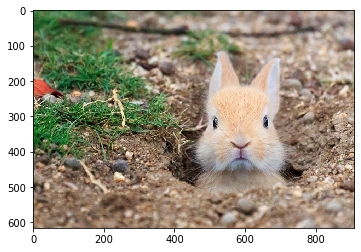

In [30]:
img_path = 'rabbit4.png'
plt.imshow(image.load_img(img_path))
plt.show()

In [31]:
img = load_image_for_inceptionv3(img_path)
 
prediction = inception_v3.predict(img)
print(decode_predictions(prediction, top=10))

[[('n02325366', 'wood_rabbit', 0.74525577), ('n02326432', 'hare', 0.15367155), ('n02328150', 'Angora', 0.0018301931), ('n02364673', 'guinea_pig', 0.000958607), ('n02971356', 'carton', 0.0007690047), ('n02356798', 'fox_squirrel', 0.0007575146), ('n03991062', 'pot', 0.0005653099), ('n07734744', 'mushroom', 0.00040683584), ('n01798484', 'prairie_chicken', 0.0004016781), ('n04204238', 'shopping_basket', 0.00039367104)]]


In [35]:
print(np.argmax(prediction))
print(pred_class[np.argmax(prediction)])

330
wood rabbit, cottontail, cottontail rabbit


# Create Mapping

In [33]:
# pred_class = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))
# pred_class

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [100]:
# # rodent: 333, 674, 357, 336, 338, 356, 106, 337, 359
# # squirrel: 335
# # rabbit: 330, 331, 332
# # bird: 10-20, 22-24, 80-100
# # deer: 350-355
# # skunk: 358, 361, 362
# # opossum, raccon: NA
# # other: 7-20, 22-106, 113-114, 127-146, 151-326, 330-388, 674 (mousetrap)
# # empty: rest

# rodent = [333, 674, 357, 336, 338, 356, 106, 337, 359]
# rodent_dict = dict(zip(rodent, ['rodent']*len(rodent)))

# squirrel_dict = {335:'squirrel'}

# rabbit = [330, 331, 332]
# rabbit_dict = dict(zip(rabbit, ['rabbit']*len(rabbit)))

# bird = list(range(10,21)) + list(range(22,25)) + list(range(80,101))
# bird_dict = dict(zip(bird, ['bird']*len(bird)))

# deer = list(range(350, 356))
# deer_dict = dict(zip(deer, ['deer']*len(deer)))

# skunk = [358, 361, 362]
# skunk_dict = dict(zip(skunk, ['skunk']*len(skunk)))

# other = list(range(7,21)) + list(range(22,107)) + [113,114] + list(range(127,147)) + \
#         list(range(151,327)) + list(range(330,389)) + [674]
# other_dict = dict(zip(other, ['other']*len(other)))

In [101]:
# new_dict = dict()
# new_dict.update(rodent_dict)
# new_dict.update(squirrel_dict)
# new_dict.update(rabbit_dict)
# new_dict.update(bird_dict)
# new_dict.update(deer_dict)
# new_dict.update(skunk_dict)
# for key in other_dict.keys():
#     if key not in new_dict.keys():
#         new_dict[key] = other_dict[key]
# for key in range(1000):
#     if key not in new_dict.keys():
#         new_dict[key] = 'empty'

In [102]:
# with open('edge/inference-service/prediction_map.pickle', 'wb') as f:
#     pickle.dump(new_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
with open('edge/inference-service/prediction_map.pickle', 'rb') as f:
    prediction_map = pickle.load(f)

# Inference on Test Set

In [26]:
def load_image(path):
    img = Image.open(path)
    img = img.resize(size=(299,299), resample=Image.LANCZOS).convert("RGB")
    img = np.array(img)
    img = img / 255.0
    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    return img

In [27]:
def test_generator(X_data, batch_size):
    i = 0
    while True:
        X_batch = []
        
        for b in range(batch_size):
            if i >= len(X_data):
                i = 0
                
            X = X_data[i]
            X = load_image(X)
            X_batch.append(X)
            i += 1
            
        yield np.array(X_batch)

In [119]:
# sample = ['squirrel1.jpg', 'squirrel2.jpg', 'squirrel3.jpg', 'squirrel4.jpg', 'squirrel5.jpg',
#           'deer1.jpg', 'deer2.jpg', 'deer3.jpg', 'deer4.jpg', 'deer5.jpg',
#           'bird1.png', 'bird2.jpg', 'bird3.jpg', 'bird4.jpg', 'bird5.jpg',
#           'rabbit1.jpg', 'rabbit2.jpg', 'rabbit3.jpg', 'rabbit4.png', 'rabbit5.jpg',
#           'rodent1.jpg', 'rodent2.jpg', 'rodent3.png', 'rodent4.jpg', 'rodent5.jpg',
#           'skunk1.jpg', 'skunk2.jpg', 'skunk3.jpg', 'skunk4.jpg', 'skunk5.jpg']

In [120]:
len(img_vector_test)

33726

In [38]:
BATCH_SIZE = 64
STEPS = len(img_vector_test)//BATCH_SIZE
generator = test_generator(img_vector_test, BATCH_SIZE)

prediction_test = inception_v3.predict(generator, verbose=1, steps=STEPS)

526/526 [==============================] - 4755s 9s/step


In [57]:
addl_pred = inception_v3.predict(test_generator(img_vector_test[-62:], 62), verbose=1, steps=1)

1/1 [==============================] - 5s 5s/step


In [58]:
addl_pred.shape

(62, 1000)

In [64]:
prediction_test = np.concatenate((prediction_test, addl_pred), axis=0)

In [65]:
prediction_test.shape

(33726, 1000)

In [63]:
with open('evaluation/predictions_test_inceptionv3_no_finetuning.pickle', 'wb') as f:
    pickle.dump(prediction_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
with open('evaluation/predictions_test_inceptionv3_no_finetuning.pickle', 'rb') as f:
    prediction_test = pickle.load(f)

In [48]:
pred_name = [prediction_map[i] for i in np.argmax(prediction_test, axis=1)]

In [49]:
true_name = [i if i not in ['opossum','raccoon'] else 'other' for i in cat_name_vector_test]

In [48]:
set(true_name)

{'bird', 'deer', 'empty', 'other', 'rabbit', 'rodent', 'skunk', 'squirrel'}

In [49]:
set(pred_name)

{'bird', 'deer', 'empty', 'other', 'rabbit', 'rodent', 'skunk', 'squirrel'}

In [52]:
len(true_name)

33726

In [51]:
len(pred_name)

33664

In [67]:
from sklearn.metrics import precision_recall_fscore_support
evaluation1 = precision_recall_fscore_support(true_name, pred_name, average='macro')
evaluation2 = precision_recall_fscore_support(true_name, pred_name, average='weighted')

In [68]:
print(evaluation1)
print(evaluation2)

(0.38587009401658745, 0.24691472839050965, 0.25287655232732104, None)
(0.5385852278162658, 0.44639150803534366, 0.42464245273263057, None)


In [76]:
labels=list(set(pred_name))
labels

['skunk', 'bird', 'rabbit', 'empty', 'other', 'deer', 'rodent', 'squirrel']

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_name, pred_name, labels=labels)

array([[   99,     1,    11,   247,    73,     0,     3,     0],
       [    2,    57,    17,   925,   324,     1,     9,     0],
       [   15,     8,   357,   331,   387,     0,     5,     0],
       [   22,   231,    16,  6963,  1472,     0,    16,     0],
       [  111,    25,   185, 10038,  7080,    39,   151,     1],
       [   11,     3,    66,  1215,  1496,   470,     3,     0],
       [   15,     0,    13,   448,   284,     0,    29,     0],
       [    3,     0,     7,   323,   115,     0,     3,     0]])

In [50]:
from sklearn.metrics import accuracy_score
accuracy_score(true_name, pred_name)

0.44387119729585484

# Inference with Fine Tuned Model

In [35]:
model_transfer = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = model_transfer.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(10, activation="softmax")(x)
model_combined = Model(model_transfer.input, x)

In [31]:
model_combined.load_weights('combined_model_2_epochs.h5')

In [32]:
model_combined.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [33]:
BATCH_SIZE = 66
STEPS = len(img_vector_test)//BATCH_SIZE
generator = test_generator(img_vector_test, BATCH_SIZE)

prediction_test = model_combined.predict(generator, verbose=1, steps=STEPS)

511/511 [==============================] - 4695s 9s/step


In [41]:
with open('evaluation/predictions_test_inceptionv3_finetuning.pickle', 'wb') as f:
    pickle.dump(prediction_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
with open('evaluation/predictions_test_inceptionv3_finetuning.pickle', 'rb') as f:
    prediction_test = pickle.load(f)

In [49]:
# removing opossum and racoon for fair comparison
pred_name = [classes_dict_lookup[i] for i in np.argmax(prediction_test, axis=1)]
pred_name = [i if i not in ['opossum','raccoon'] else 'other' for i in pred_name]

In [50]:
true_name = [i if i not in ['opossum','raccoon'] else 'other' for i in cat_name_vector_test]

In [51]:
from sklearn.metrics import precision_recall_fscore_support
evaluation1 = precision_recall_fscore_support(true_name, pred_name, average='macro')
evaluation2 = precision_recall_fscore_support(true_name, pred_name, average='weighted')

In [52]:
print(evaluation1)
print(evaluation2)

(0.3320186017819308, 0.46444282003655446, 0.331335214464299, None)
(0.7268668837391435, 0.5188578544742928, 0.5742418842803874, None)


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_name, pred_name, labels=labels)

In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(true_name, pred_name)

0.5188578544742928

# Inference with Top Layer Model

In [27]:
transfer_input = Input(shape=(8,8,2048))
x = GlobalAveragePooling2D()(transfer_input)
x = Dense(128, activation="relu")(x)
x = Dropout(0.8)(x)
x = Dense(10, activation="softmax")(x)
model = Model(transfer_input, x)

In [28]:
model.load_weights('model_4.h5')

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 263,562
Trainable params: 263,562
Non-trainable params: 0
_________________________________________________________________


In [30]:
def load_encoding(path):
    return np.load(path.replace('cct_images', 'test') + '.npy')

In [31]:
def generator_encoded(X_data, batch_size):
    i = 0
    while True:
        X_batch = []

        for b in range(batch_size):
            if i >= len(X_data):
                i = 0
                
            X = load_encoding(X_data[i])
            X_batch.append(X)
            i += 1
            
        yield np.array(X_batch)

In [32]:
BATCH_SIZE = 66
STEPS = len(img_vector_test)//BATCH_SIZE
generator = generator_encoded(img_vector_test, BATCH_SIZE)

prediction_test = model.predict(generator, verbose=1, steps=STEPS)

511/511 [==============================] - 1789s 4s/step


In [33]:
with open('evaluation/predictions_test_inceptionv3_top_layer.pickle', 'wb') as f:
    pickle.dump(prediction_test, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('evaluation/predictions_test_inceptionv3_top_layer.pickle', 'rb') as f:
    prediction_test = pickle.load(f)

In [35]:
classes = ['rodent','squirrel','rabbit','bird','deer','raccoon','skunk','opossum']
classes_dict = dict(zip(classes + ['other'] + ['empty'], range(10)))
classes_dict_lookup = dict(zip(range(10), classes + ['other'] + ['empty']))

In [36]:
# removing opossum and racoon for fair comparison
pred_name = [classes_dict_lookup[i] for i in np.argmax(prediction_test, axis=1)]
pred_name = [i if i not in ['opossum','raccoon'] else 'other' for i in pred_name]

In [37]:
true_name = [i if i not in ['opossum','raccoon'] else 'other' for i in cat_name_vector_test]

In [38]:
set(pred_name)

{'bird', 'deer', 'empty', 'other', 'rabbit', 'rodent', 'skunk', 'squirrel'}

In [39]:
set(true_name)

{'bird', 'deer', 'empty', 'other', 'rabbit', 'rodent', 'skunk', 'squirrel'}

In [40]:
from sklearn.metrics import precision_recall_fscore_support
evaluation1 = precision_recall_fscore_support(true_name, pred_name, average='macro')
evaluation2 = precision_recall_fscore_support(true_name, pred_name, average='weighted')

In [44]:
print(evaluation1)
print(evaluation2)

(0.3642329345295856, 0.5331056058422421, 0.34262234432913424, None)
(0.7528029836535064, 0.49516693352309793, 0.5575859459765432, None)


In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_name, pred_name, labels=labels)

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(true_name, pred_name)

0.49516693352309793

In [36]:
img_path = 'squirrel1.jpg'
img = load_image_for_inceptiwith open('evaluation/predictions_test_inceptionv3_finetuning.pickle', 'wb') as f:
    pickle.dump(prediction_test, f, protocol=pickle.HIGHEST_PROTOCOL)

pred_name = [classes_dict_lookup[i] for i in np.argmax(prediction_test, axis=1)]

true_name = [i if i not in ['opossum','raccoon'] else 'other' for i in cat_name_vector_test]onv3(img_path)

In [37]:
pred = model_transfer.predict(img)
pred2 = model.predict(pred)

In [43]:
classes_dict_lookup[pred2.argmax()]

'squirrel'

# Tensorflow Lite and Quantization

In [268]:
converter = tf.lite.TFLiteConverter.from_keras_model(inception_v3)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open("edge/model/converted_quant_model_v2.tflite", "wb").write(tflite_quant_model)

95310940

# Run Inference on TF Lite Model

In [317]:
#import tflite_runtime.interpreter as tflite

In [86]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="edge/model/converted_quant_model_v2.tflite")
interpreter.allocate_tensors()

In [87]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [88]:
input_details

[{'name': 'input_1',
  'index': 312,
  'shape': array([  1, 299, 299,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [89]:
output_details

[{'name': 'Identity',
  'index': 0,
  'shape': array([   1, 1000], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [122]:
img_path = 'test3.jpeg'
img = load_image_for_inceptionv3(img_path)

In [123]:
# Test model on random input data.
#input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], img)

In [124]:
interpreter.invoke()

In [125]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
prediction = interpreter.get_tensor(output_details[0]['index'])

353
gazelle
deer


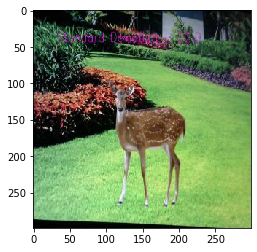

In [126]:
print(np.argmax(prediction))
print(pred_class[np.argmax(prediction)])
print(prediction_map[np.argmax(prediction)])
plt.imshow(image.load_img(img_path))
plt.show()

In [127]:
prediction.argmax()

353

In [128]:
prediction.max()

0.85817295

# End of Main Code

[[('n01580077', 'jay', 0.72900456), ('n01806567', 'quail', 0.028316636), ('n01537544', 'indigo_bunting', 0.026563805)]]


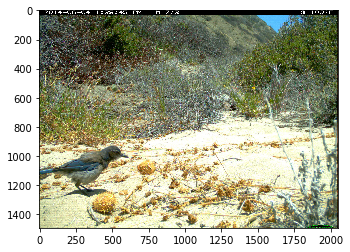

In [108]:
img_path = img_vector_train[18]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
 
features = inception_v3.predict(x)
print(decode_predictions(features, top = 3))
 
plt.imshow(image.load_img(img_path))
plt.show()

[[('n02423022', 'gazelle', 0.78349143), ('n02422699', 'impala', 0.05957584), ('n02415577', 'bighorn', 0.04937292)]]


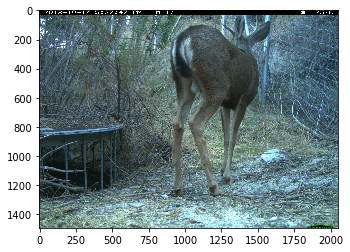

In [103]:
img_path = img_vector_train[9]
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)
 
features = inception_v3.predict(x)
print(decode_predictions(features, top = 3))
 
plt.imshow(image.load_img(img_path))
plt.show()